In [3]:
from segment_lidar import samlidar, view
import pylas
import open3d as o3d
import numpy as np
import laspy
import cv2
import matplotlib.pyplot as plt


## First we define function to convert files 

PCD -> LAS
LAS -> PCD

In [4]:
def convert_pcd_to_las(pcd_file=None, point_cloud=None, las_file="downsampled.las"):
    if(pcd_file is None and point_cloud is None):
        print("No input file")
        return
    # Read the PCD file
    if point_cloud is None:
        pcd = o3d.io.read_point_cloud(pcd_file)
    else:
        pcd = point_cloud
    
    # Extract points and colors from the PCD file
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)
    
    r = colors[:, 0]
    g = colors[:, 1]
    b = colors[:, 2]
    
    # Create a LAS file with RGB fields
    las = pylas.create(point_format_id=3)
    las.x = points[:, 0]
    las.y = points[:, 1]
    las.z = points[:, 2]
    las.red = r
    las.green = g
    las.blue = b
    
    # Write the LAS file
    las.write(las_file)
    return las_file
    
def convert_las_to_pcd(las) -> o3d.t.geometry.PointCloud:
    # get points
    points = np.vstack((las.x, las.y, las.z)).transpose()
    print("point len : ",  len(points))

    # make blank cloud
    pcd = o3d.geometry.PointCloud()

    # add x,y,z to o3d cloud
    pcd.points = o3d.utility.Vector3dVector(points)

    # if rgb present, convert to o3d colors
    all_dims = list(las.point_format.dimension_names)[3:]
    
    if "red" in all_dims and "green" in all_dims and "blue" in all_dims:
        colors = np.vstack((las.red, las.green, las.blue)).transpose()
        pcd.colors = o3d.utility.Vector3dVector(colors)
        all_dims.remove("blue")
        all_dims.remove("green")
        all_dims.remove("red")
    return pcd


## Voxel function for downsampling PCD files

In [5]:
def voxel_downsample(pcd, nb_points, voxelvalue = 1): # Increase voxel size to reduce memory usage
    '''
    If your pointcloud file is expressed in meters, voxel_size=0.05 will mean the voxel grid will be made up of voxels measuring 5 x 5 x 5 cm. 
    After filtering the pointcloud density is reduced so that you have only one point per such voxel. 
    '''
    downsample = pcd.voxel_down_sample(voxelvalue)
    print("before : ", pcd, ", after : ", downsample)
    nb_points.append(len(np.asarray(downsample.points)))
    return downsample, nb_points

## Run the Lidar segment algo

In [6]:
#Obviously this function could take a while....
def compute_segment_lidar(input_file, save_path, labeled_tif_path, raster_tif_path):
    viewpoint = view.TopView()

    model = samlidar.SamLidar(ckpt_path="sam_vit_h_4b8939.pth")
    points = model.read(input_file)
    labels, *_ = model.segment(points=points, view=viewpoint, labels_path=labeled_tif_path, image_path=raster_tif_path)
    model.write(points=points, segment_ids=labels, save_path=save_path)
    return save_path, labeled_tif_path
    

## Benchmark functions

In [7]:
# base on the labeled image generate by lidar-segment

def benchmark(labeled_tif_path, nb_contour_list):
    image = cv2.imread(labeled_tif_path)
    # convert the image to grayscale format
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # apply binary thresholding
    ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY)
    
    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    
    nb_contours = len(contours)
    nb_contour_list.append(nb_contours)
    return nb_contour_list, contours


# Main loop

Loop arrangement : 

- Start with a .las file
<ul>
    <li>Convert to pcd</li>
    <li>Downsamp the file</li>
    <li>Convert to las</li>
    <li>Run Lidar-segment model</li>
    <li>Compute test benchmark of the labeled/rester images</li>
</ul>

Iteration number :  0
point len :  38266035
before :  PointCloud with 38266035 points. , after :  PointCloud with 9871184 points.
Reading downsampled.las...
- Classification value is not provided. Reading all points...
- Reading RGB values...
File reading is completed in 1.57 seconds. The point cloud contains 9871184 points.

/home/savinien/Documents/Polonie/lidar-segment/lidar-segment/labeled.tif  now OK
- Generating raster image...
- Saving raster image...
- Applying segment-geospatial to raster image...
- Saving segmented image...
- Generating segment IDs...
Segmentation is completed in 225.73 seconds. Number of instances: 140

Writing the segmented point cloud to downsample_computed.las...
Writing is completed in 5.46 seconds.

Iteration number :  1
point len :  9871184
before :  PointCloud with 9871184 points. , after :  PointCloud with 2899720 points.
Reading downsampled.las...
- Classification value is not provided. Reading all points...
- Reading RGB values...
File reading is c

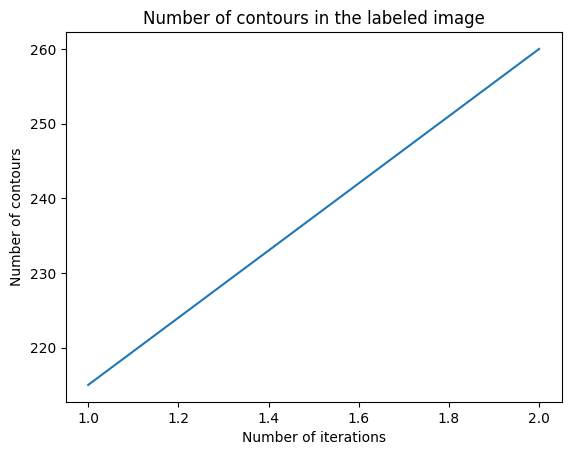

In [ ]:
las = laspy.read("../../../scan_PUT/block_5.las")
nb_iteration = 5
voxel_size = 0.12

label_path = "/home/savinien/Documents/Polonie/lidar-segment/lidar-segment/labeled.tif"
raster_path ="/home/savinien/Documents/Polonie/lidar-segment/lidar-segment/raster.tif"

las_downsample = "downsampled.las"
las_downsample_computed = "downsample_computed.las"

nb_contour_list = list()
nb_pointcloud = list()
contours = list()

for i in range(nb_iteration):
    print("Iteration number : ", i)
    if(i == 0):
        pcd_before = convert_las_to_pcd(las)
        pcd_downsample, nb_pointcloud_after = voxel_downsample(pcd_before, nb_pointcloud, voxel_size)
    else:
        las = laspy.read(las_downsample)
        pcd_before = convert_las_to_pcd(las)
        pcd_downsample, nb_pointcloud_after = voxel_downsample(pcd_before, nb_pointcloud, voxel_size * 2)
    
    nb_pointcloud = nb_pointcloud_after

    las_downsample = convert_pcd_to_las(point_cloud=pcd_downsample, las_file=las_downsample)

    compute_segment_lidar(las_downsample, las_downsample_computed, label_path, raster_path)

    # Run benchmark
    nb_contour_list, contour = benchmark(label_path, nb_contour_list)
    contours.append(contour)
    
xs = [x+1 for x in range(len(nb_contour_list))]
plt.plot(xs, nb_contour_list)
plt.xlabel("Number of iterations")
plt.ylabel("Number of contours")
plt.title("Number of contours in the labeled image")
plt.show()


## Save each contour as a file 

In [9]:
# Just need few processing before....
final_contours = list()
print(len(contours))
for contour in contours:
    print(len(contour))
    for cont in contour:
       final_contours.append(cont)

2
215
260


Nombre de contours trouvés: 475


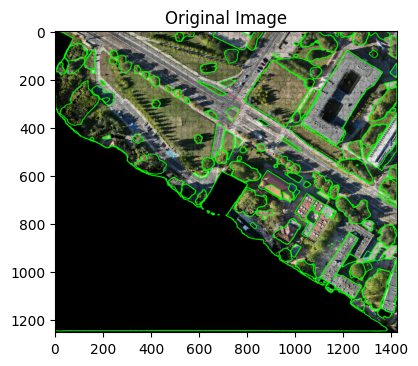

In [13]:
import os

if not os.path.exists('../data'):
    os.makedirs('../data')
image = cv2.imread(raster_path)

if image is None:
    print("Erreur: l'image n'a pas pu être chargée.")
else:    
    print(f"Nombre de contours trouvés: {len(final_contours)}")
    
    # Parcourir chaque contour et enregistrer les sous-images
    for i, contour in enumerate(final_contours):
        x, y, w, h = cv2.boundingRect(contour)
        roi = image[y:y+h, x:x+w]
        
        # Vérifiez que la région d'intérêt n'est pas vide
        if roi.size > 0:
            cv2.imwrite(f'../data/contour_{i}.png', roi)
    
    # draw contours on the original image
    image_copy = image.copy()
    cv2.drawContours(image=image_copy, contours=final_contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

    # Visualize the masks and contours
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.show()